In [1]:
import numpy as np
import gymnasium as gym
from moviepy import ImageSequenceClip # to generate gif
from IPython.display import Image
import math
import matplotlib 
#matplotlib.use('Qt5Agg') # Activte it if you want external plot for any interaction
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### 🏋️‍♂️ CartPole-v1 Discretization Function

CartPole has **4 continuous state variables**:

 **1**. Cart position

 **2**. Cart velocity

 **3**. Pole angle

 **4**. Pole angular velocity

We’ll discretize these into bins.

In [2]:


def discretize_cartpole_state(observation, state_bins):
    """
    Convert a continuous CartPole state into a discrete index for Q-learning.

    Parameters:
        observation : array-like of shape (4,)
            [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
        state_bins : list or array-like of length 4
            Number of bins for each state dimension, e.g. [6, 6, 12, 6]

    Returns:
        int
            A single integer index representing the discretized state.
    """
    cart_pos, cart_vel, pole_ang, pole_ang_vel = observation

    # Define reasonable thresholds for state variables
    cart_pos_limit = 4.8       # track ends at about ±4.8
    cart_vel_limit = 3.0       # max reasonable velocity
    pole_ang_limit = math.radians(15)  # about ±15 degrees
    pole_ang_vel_limit = math.radians(50)

    # Create bin edges for each state variable
    cart_pos_bins = np.linspace(-cart_pos_limit, cart_pos_limit, state_bins[0] + 1)
    cart_vel_bins = np.linspace(-cart_vel_limit, cart_vel_limit, state_bins[1] + 1)
    pole_ang_bins = np.linspace(-pole_ang_limit, pole_ang_limit, state_bins[2] + 1)
    pole_ang_vel_bins = np.linspace(-pole_ang_vel_limit, pole_ang_vel_limit, state_bins[3] + 1)

    # Digitize each continuous value into a discrete bucket
    cart_pos_idx = np.digitize(cart_pos, cart_pos_bins) - 1
    cart_vel_idx = np.digitize(cart_vel, cart_vel_bins) - 1
    pole_ang_idx = np.digitize(pole_ang, pole_ang_bins) - 1
    pole_ang_vel_idx = np.digitize(pole_ang_vel, pole_ang_vel_bins) - 1

    # Clip indices to avoid overflow (in case value exceeds limits)
    cart_pos_idx = np.clip(cart_pos_idx, 0, state_bins[0] - 1)
    cart_vel_idx = np.clip(cart_vel_idx, 0, state_bins[1] - 1)
    pole_ang_idx = np.clip(pole_ang_idx, 0, state_bins[2] - 1)
    pole_ang_vel_idx = np.clip(pole_ang_vel_idx, 0, state_bins[3] - 1)

    # Combine all indices into a single integer (multi-dimensional → 1D)
    index = (cart_pos_idx * state_bins[1] * state_bins[2] * state_bins[3] +
             cart_vel_idx * state_bins[2] * state_bins[3] +
             pole_ang_idx * state_bins[3] +
             pole_ang_vel_idx)

    return int(index)


### 🚗 MountainCar-v0 Discretization Function

MountainCar has only **2 continuous state variables**:

 **1**. Car position

 **2**. Car velocity

The agent must learn to move between the valleys using momentum.

In [3]:
def discretize_mountaincar_state(observation, state_bins):
    """
    Convert a continuous MountainCar state into a discrete index for Q-learning.

    Parameters:
        observation : array-like of shape (2,)
            [position, velocity]
        state_bins : list or array-like of length 2
            Number of bins for each dimension, e.g. [20, 20]

    Returns:
        int
            A single integer index representing the discretized state.
    """
    car_position, car_velocity = observation

    # Define the known limits for MountainCar-v0
    position_min, position_max = -1.2, 0.6
    velocity_min, velocity_max = -0.07, 0.07

    # Create bin edges
    position_bins = np.linspace(position_min, position_max, state_bins[0] + 1)
    velocity_bins = np.linspace(velocity_min, velocity_max, state_bins[1] + 1)

    # Digitize (find which bin each variable falls into)
    pos_idx = np.digitize(car_position, position_bins) - 1
    vel_idx = np.digitize(car_velocity, velocity_bins) - 1

    # Clip indices to stay within range
    pos_idx = np.clip(pos_idx, 0, state_bins[0] - 1)
    vel_idx = np.clip(vel_idx, 0, state_bins[1] - 1)

    # Combine into one index
    index = pos_idx * state_bins[1] + vel_idx

    return int(index)


In [4]:

def initialize_q_table(state_bins, num_actions):
    """
    Create and initialize a Q-table for a discretized continuous environment.

    Parameters:
        state_bins : list or array-like
            Number of bins per state dimension, e.g. [6, 6, 12, 6]
        num_actions : int
            Number of possible discrete actions in the environment.

    Returns:
        np.ndarray
            A Q-table of shape (num_states, num_actions), initialized to zeros.
    """
    # Total number of discrete states = product of all bins
    num_states = int(np.prod(state_bins))
    
    # Initialize Q-table with zeros (or small random numbers)
    q_table = np.zeros((num_states, num_actions))

    return q_table


In [5]:


def epsilon_greedy_action(env, q_table, state_index, epsilon):
    """
    Select an action using the epsilon-greedy policy.

    This strategy balances exploration and exploitation:
    - With probability ε (epsilon), choose a random action (exploration).
    - With probability (1 - ε), choose the best-known action (exploitation).

    Parameters:
        env : gym.Env
            The environment, used to sample random actions.
        q_table : np.ndarray
            The Q-table storing estimated action values for each state.
            Shape: (num_states, num_actions)
        state_index : int
            The index of the current discrete state in the Q-table.
        epsilon : float
            The exploration rate (0 ≤ ε ≤ 1). Higher means more exploration.

    Returns:
        int
            The selected action (integer from 0 to env.action_space.n - 1).
    """

    # Generate a random number between 0 and 1
    random_value = np.random.random()

    # With probability epsilon → explore (pick a random action)
    if random_value < epsilon:
        action = env.action_space.sample()
    else:
        # Otherwise → exploit (choose the action with the highest Q-value)
        action = np.argmax(q_table[state_index])

    return action


In [6]:
def Train_SARSA(env_name, episodes_num, printout, alpha=0.1, gamma=0.99, epsilon=0.1):
    
    env = gym.make(env_name)
    
    if('CartPole' in env_name):
        state_bins = [6, 6, 12, 6]
    if('MountainCar' in env_name):
        state_bins = [20, 20]
    # Initializing the Q table
    n_actions = env.action_space.n
    Q_table = initialize_q_table(state_bins,n_actions)
    
    
    episode_rewards = []
    episode_lengths = []
    
    
    for episode in range(episodes_num):
        
        
        state, _ = env.reset()
        if('CartPole' in env_name):
            state_idx = discretize_cartpole_state(state, state_bins)
        if('MountainCar' in env_name):
            state_idx = discretize_mountaincar_state(state, state_bins)
            
        # epsilon greedy
        action = epsilon_greedy_action(env, Q_table, state_idx, epsilon)
           

        done = False
        total_reward = 0
        steps = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated #or truncated
            
            if('CartPole' in env_name):
                next_state_idx = discretize_cartpole_state(next_state, state_bins)
            if('MountainCar' in env_name):    
                next_state_idx = discretize_mountaincar_state(next_state, state_bins)

            # epsilon greedy
            next_action = epsilon_greedy_action(env, Q_table, next_state_idx, epsilon)
           
            # SARSA update on Q-table
            Q_table[state_idx, action] += alpha * (
                                        reward + gamma * Q_table[next_state_idx, next_action] - Q_table[state_idx, action]
                                    )

            state = next_state
            state_idx = next_state_idx
            action = next_action
            total_reward += reward
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

        avg_reward = np.mean(episode_rewards[-100:])
        
        # Early stop condition
        if(avg_reward>700 and 'CartPole' in env_name) or (avg_reward>-150 and 'MountainCar' in env_name):
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")
            break

        if episode % printout == 0: # printout the training progress
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")
            

    env.close()
    return Q_table, episode_rewards, episode_lengths
     

In [7]:
# This functions are for visualization of episodes after training
# -------------------------
# Render Episodes Using RGB Frames
# -------------------------



def create_gif(frames, filename, fps=5):
    """Creates a GIF animation from a list of frames."""
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)

    
    
def run_multi_episodes(env_name, Q_table, run_num=10):
    """Run a single episode using the learned Q-table."""
    env = gym.make(env_name, render_mode='rgb_array')
    
    if('CartPole' in env_name):
        state_bins = [6, 6, 12, 6]
    if('MountainCar' in env_name):
        state_bins = [20, 20]
    
    total_frames = []
    total_reward = []
    for run in range(run_num):
        state, _ = env.reset()
        
        if('CartPole' in env_name):
            state_idx = discretize_cartpole_state(state, state_bins)
        if('MountainCar' in env_name):
            state_idx = discretize_mountaincar_state(state, state_bins)
            
        done = False
        episode_reward = 0
        frames = [env.render()]

        while not done:
            action = np.argmax(Q_table[state_idx])
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            if('CartPole' in env_name):
                next_state_idx = discretize_cartpole_state(next_state, state_bins)
            if('MountainCar' in env_name):    
                next_state_idx = discretize_mountaincar_state(next_state, state_bins)
            
            done = terminated or truncated
            
            frames.append(env.render())
            episode_reward += reward
            state_idx = next_state_idx
            
        total_frames.extend(frames)
        total_reward.append(episode_reward)
    return total_frames, total_reward

## Experiment for CartPole

In [8]:
# Continuous states space

learned_Q_table, episode_rewards, episode_lengths = Train_SARSA('CartPole-v1', 
                                                                20000, # total episodes
                                                                500,  # printout every 500 episodes
                                                                alpha=0.1, 
                                                                gamma=0.99, 
                                                                epsilon=0.1)


Episode 0, Avg Reward: 15.00, Avg Length: 15.00
Episode 500, Avg Reward: 12.65, Avg Length: 12.65
Episode 1000, Avg Reward: 17.57, Avg Length: 17.57
Episode 1500, Avg Reward: 19.12, Avg Length: 19.12
Episode 2000, Avg Reward: 20.16, Avg Length: 20.16
Episode 2500, Avg Reward: 20.42, Avg Length: 20.42
Episode 3000, Avg Reward: 22.66, Avg Length: 22.66
Episode 3500, Avg Reward: 33.31, Avg Length: 33.31
Episode 4000, Avg Reward: 48.11, Avg Length: 48.11
Episode 4447, Avg Reward: 711.10, Avg Length: 711.10


In [9]:
# plot return and length for episodes
# plots will be saved into the project folder
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode Return")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title("Episode Lengths")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")

plt.tight_layout()
plt.savefig(f'learning_progress_CartPole.png', bbox_inches='tight',  dpi=100)
plt.close()

In [10]:
print('Playing an episode ...')
total_frames, total_reward = run_multi_episodes('CartPole-v1', learned_Q_table, run_num=1)
print(f'Total reward: {total_reward}')
print('Generating GIF please wait ...')
create_gif(total_frames, 'CartPole_SARSA.gif', fps=25)
print('GIF is ready!')

Playing an episode ...
Total reward: [500.0]
Generating GIF please wait ...
MoviePy - Building file CartPole_SARSA.gif with imageio.


GIF is ready!


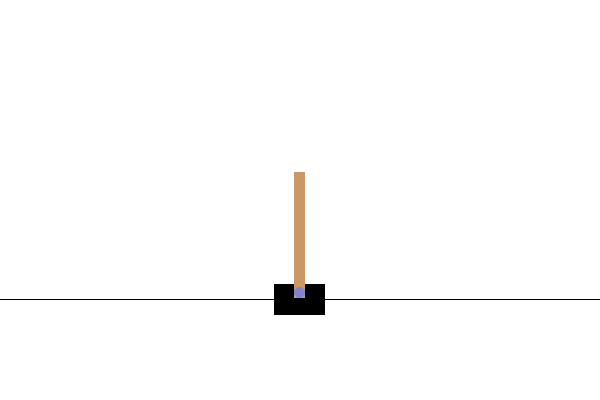

In [11]:
Image("./CartPole_SARSA.gif")

<br><br>

---

<br><br>

## Experiment for MountainCar

In [12]:
# Continuous states space

learned_Q_table, episode_rewards, episode_lengths = Train_SARSA('MountainCar-v0', 
                                                                20000, # total episodes
                                                                200,  # printout every 200 episodes
                                                                alpha=0.1, 
                                                                gamma=0.99, 
                                                                epsilon=0.1)


Episode 0, Avg Reward: -7733.00, Avg Length: 7733.00
Episode 200, Avg Reward: -448.06, Avg Length: 448.06
Episode 400, Avg Reward: -276.37, Avg Length: 276.37
Episode 600, Avg Reward: -286.37, Avg Length: 286.37
Episode 800, Avg Reward: -234.79, Avg Length: 234.79
Episode 1000, Avg Reward: -248.49, Avg Length: 248.49
Episode 1200, Avg Reward: -206.65, Avg Length: 206.65
Episode 1400, Avg Reward: -212.98, Avg Length: 212.98
Episode 1600, Avg Reward: -188.20, Avg Length: 188.20
Episode 1800, Avg Reward: -191.20, Avg Length: 191.20
Episode 2000, Avg Reward: -216.82, Avg Length: 216.82
Episode 2200, Avg Reward: -179.62, Avg Length: 179.62
Episode 2400, Avg Reward: -186.14, Avg Length: 186.14
Episode 2600, Avg Reward: -173.32, Avg Length: 173.32
Episode 2800, Avg Reward: -182.19, Avg Length: 182.19
Episode 3000, Avg Reward: -176.34, Avg Length: 176.34
Episode 3200, Avg Reward: -189.16, Avg Length: 189.16
Episode 3400, Avg Reward: -173.86, Avg Length: 173.86
Episode 3600, Avg Reward: -174.57

In [13]:
# plot return and length for episodes
# plots will be saved into the project folder
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode Return")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title("Episode Lengths")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")

plt.tight_layout()
plt.savefig(f'learning_progress_MountainCar.png', bbox_inches='tight',  dpi=100)
plt.close()

In [14]:
print('Playing an episode ...')
total_frames, total_reward = run_multi_episodes('MountainCar-v0', learned_Q_table, run_num=3)
print(f'Total reward: {total_reward}')
print('Generating GIF please wait ...')
create_gif(total_frames, 'MountainCar_SARSA.gif', fps=25)
print('GIF is ready!')

Playing an episode ...
Total reward: [-158.0, -126.0, -158.0]
Generating GIF please wait ...
MoviePy - Building file MountainCar_SARSA.gif with imageio.


GIF is ready!


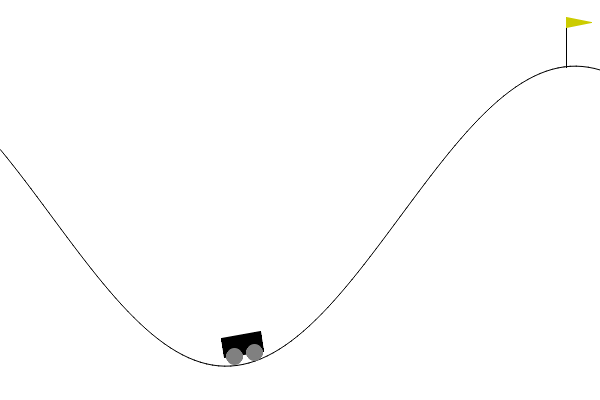

In [15]:
Image("./MountainCar_SARSA.gif")